In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

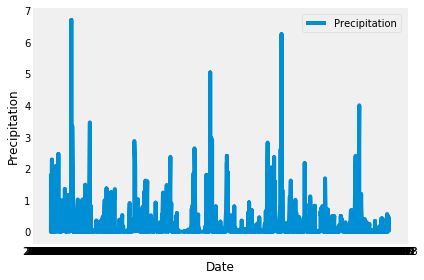

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
from datetime import datetime
from dateutil.relativedelta import relativedelta
dates = session.query(Measurement).order_by(Measurement.date.desc())
count = 0
year_dates = []
year_prcp = []
for date in dates:
    date_new = date.date
    date_new = datetime.strptime(date_new, "%Y-%m-%d")
    if count==0:
        end_date = date_new - relativedelta(months=+12)
        count+=1
    if date_new >= end_date:
        if(date.prcp != None):
            year_prcp.append(date.prcp)
            year_dates.append(date.date)
# Save the query results as a Pandas DataFrame and set the index to the date column
year_data = pd.DataFrame({"Date":year_dates, "Precipitation":year_prcp})
year_data = year_data.set_index("Date")
# Sort the dataframe by date
year_data = year_data.sort_values(by=['Date'])
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(year_data, label="Precipitation")
plt.legend(loc="best")
plt.xlabel("Date")
plt.grid()
plt.ylabel("Precipitation")
plt.tight_layout()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
stats_numeric = year_data["Precipitation"].describe()
stats_df = pd.DataFrame(stats_numeric)
stats_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(func.distinct(Measurement.station)).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(func.distinct(Measurement.station),func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_name = [station[0] for station in stations]
station_name = station_name[0]

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_name).all()

[(54.0, 85.0, 71.66378066378067)]

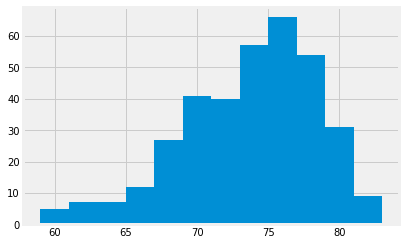

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#==========Get most recent date and format it======
temp_query_date = session.query(Measurement.date).filter(Measurement.station == station_name).\
    order_by(Measurement.date.desc()).all()
temp_query_date = [temp_query_date[0] for temp_query_date in temp_query_date]
temp_query_dates = datetime.strptime(temp_query_date[0], "%Y-%m-%d")
#==========Get most recent date and format it======

#query
temp_query = session.query(Measurement.tobs).filter(Measurement.station == station_name).\
    filter(Measurement.date >= (temp_query_dates - dt.timedelta(days=365))).all()
#format
temp_query = [temp_query[0] for temp_query in temp_query]

plt.hist(temp_query, bins=12)
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
ptps = calc_temps('2011-02-28', '2011-03-05')
avg = [ptps[1] for ptps in ptps]
min = [ptps[0] for ptps in ptps]
max = [ptps[2] for ptps in ptps]
print(ptps)

[(61.0, 69.75510204081633, 75.0)]


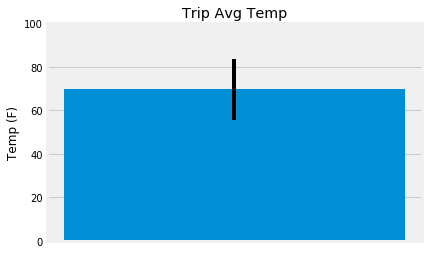

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# # Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

diff =  max[0]-min[0]
plt.bar(0, avg, yerr=diff)
plt.ylabel('Temp (F)')
plt.yticks(np.arange(0, 110, 20))
plt.xticks([])
plt.title('Trip Avg Temp')
plt.show()